In [2]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import csv
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
import keras
from functools import partial
# from keras.backend import sigmoid
from math import exp
from tensorflow.keras.utils import get_custom_objects
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Bidirectional 
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate
from keras.layers import Input
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report 
import joblib
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns


2024-08-13 21:11:09.364997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 21:11:09.375939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 21:11:09.388816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 21:11:09.392708: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 21:11:09.402284: I tensorflow/core/platform/cpu_feature_guar

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set only the first GPU as visible
        tf.config.set_visible_devices(gpus[0], 'GPU')
        # Allow memory growth to allocate memory dynamically on the GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU configuration successful.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected.")

GPU configuration successful.


In [5]:
def load_data(data_path):
    """Loads training dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)
   
    X = np.array(data["MFCCs"])
    
    y = np.array(data["labels"])
    #y = y -1
    print("Training sets loaded!")
    
    print(X.shape)
    
    return X, y

In [6]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.
    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation
    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """

    # load dataset
    X, y = load_data(data_path)
    #print(X.shape)
    
    ################################## Scaleing the data #############################
    scaler = StandardScaler()
    num_instances, num_time_steps, num_features = X.shape
    #print(num_instances)
    #print(num_time_steps)
    #print(num_features)
    #X = np.reshape(X, shape=(-1, num_features))
    X = X.reshape(-1, num_features)
    #print(X.shape)
    X = scaler.fit_transform(X)
    
    #####################################
    # Save the scaler to a file
    joblib.dump(scaler, './scaler/scaler_8000.pkl')
    #####################################
    
    #reshapeing
    #X = np.reshape(X, shape=(num_instances, num_time_steps, num_features))
    X = X.reshape(num_instances, num_time_steps, num_features) 
    #print(X.shape)
    ##################################################################################
    
    # create train, validation, test split
    X_train_1, X_test, y_train_1, y_test = train_test_split(X,y, stratify= y, test_size=test_size, random_state=50)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_1,y_train_1,  stratify= y_train_1, test_size=validation_size, random_state=50)


    print(X_train.shape)
    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    
#     y_train = y_train.astype(np.float64)
#     y_validation = y_validation.astype(np.float64)
#     print(X_train.dtype)
#     print(y_train.dtype)
#     print(X_validation.dtype)
#     print(y_validation.dtype)

    
    


    return X_train, y_train, X_validation, y_validation, X_test, y_test


In [7]:
DATA_PATH = "/home/soumen/Soumen/feature/KWS/project_1/data.json"

EPOCHS = 350
BATCH_SIZE = 128
PATIENCE = 5
LEARNING_RATE = 0.0001
SKIP = 1
CLASS =6

In [8]:
#EPOCHS = 350
# Define your class names correctly
Class = ['down', 'up', 'on', 'unknown', 'background_noise', 'off']

In [9]:
# generate train, validation and test sets
X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)
#print(y_test)
#print(np.isnan(y_train))


Training sets loaded!
(22590, 61, 13)
(14457, 61, 13)


# MFCCs

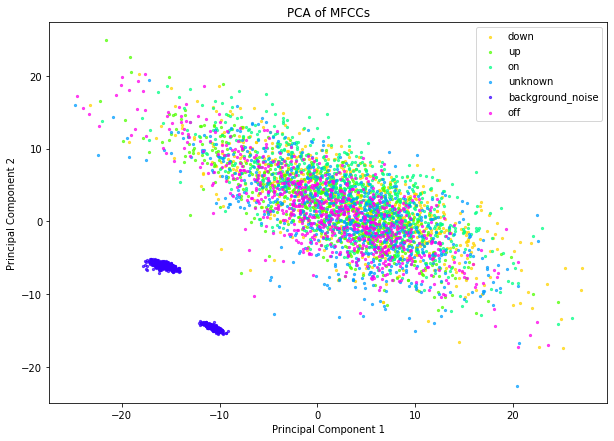

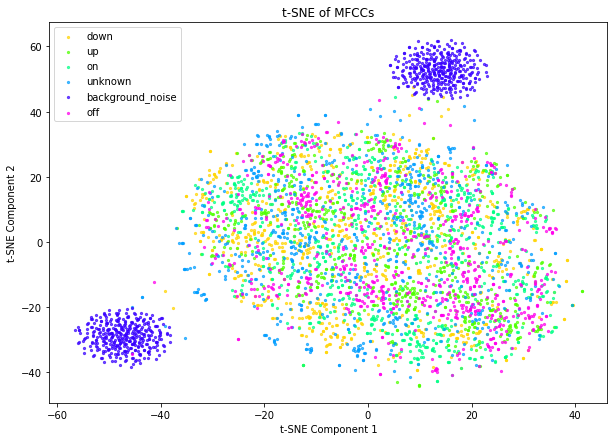

In [20]:

# create network
# input_shape = (X_train.shape[1], X_train.shape[2], 1)
# print(X_train.shape)
# print(y_train.shape)
#model = build_model(input_shape, learning_rate=LEARNING_RATE)


# Making predictions on the test set
#y_pred_probs = model.predict(X_test)  # Assuming model output probabilities for each class

# Assuming X_test is of shape (num_samples, dim1, dim2, dim3)
num_samples, dim1, dim2, dim3 = X_test.shape

# Reshape X_test to (num_samples, dim1 * dim2 * dim3)
X_test_flattened = X_test.reshape(num_samples, dim1 * dim2 * dim3)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_test_flattened)

# Plot the data with different colors for different classes
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(Class))  # Choose a color palette

for i, label in enumerate(Class):
    idx = y_test == i
    plt.scatter(principal_components[idx, 0], principal_components[idx, 1], 
                s=5, alpha=0.7, color=palette[i], label=Class[i])

plt.title('PCA of MFCCs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_test_flattened)

# Plot the data with different colors for different classes
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(Class)) # Choose a color palette

for i, label in enumerate(Class):
    idx = y_test == i
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], s=5, alpha=0.7, color=palette[i], label=Class[i])

plt.title('t-SNE of MFCCs')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

# 2D-CNN

In [63]:
# concatenate the models

# import concatenate layer
from tensorflow.keras.layers import Concatenate
from keras.layers import Input

def build_model(input_shape, learning_rate, loss="sparse_categorical_crossentropy"):
    model = tf.keras.models.load_model('/home/soumen/Soumen/model/KWS/project_1/2D_CNN.keras')
    
    # # Get the number of layers in the pre-trained model
    num_layers = len(model.layers)
    #print(num_layers)

#    # Extract and print the weights of each layer
#     for i, layer in enumerate(model.layers):
#         if layer.trainable:
#             print(f"Layer {i}: {layer.name}")
#             weights = layer.get_weights()
            
#             #print(weights)
#             if weights:
#                 for j, w in enumerate(weights):
#                     print(f"  Weight {j}: shape={w.shape}")
                    
#             else:
#                 print("  No trainable weights")

     # Extract the input of fast layer
    input_layer_input = model.layers[-9].input
    #print(input_layer_input.shape)
    # Extract the output of the second last layer
    last_layer_output = model.layers[-3].output   #-2
    #print(last_layer_output.shape)


    # Freeze all layers except the last one
    count = 0
    for layer in model.layers[:-3]:    #-1
        layer.trainable = False
        count += 1
        #print(count)
    
    
     # Create the transfer learning model using Functional API
    model = Model(inputs=input_layer_input, outputs=last_layer_output)

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)  #, decay=0.0)

    model.compile(optimizer=optimiser, loss=loss,metrics=["accuracy"])  

    model.summary()
    
    return model

(14457, 61, 13, 1)
(14457,)


Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 61, 13, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 13, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 61, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 31, 7, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 31, 7, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,488 (76.12 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,488 (76.12 KB)

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


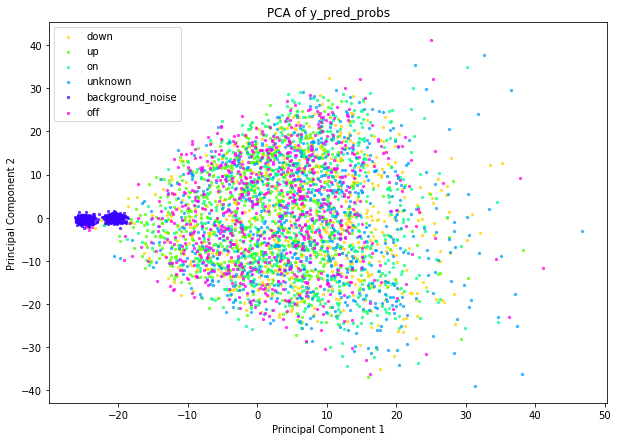

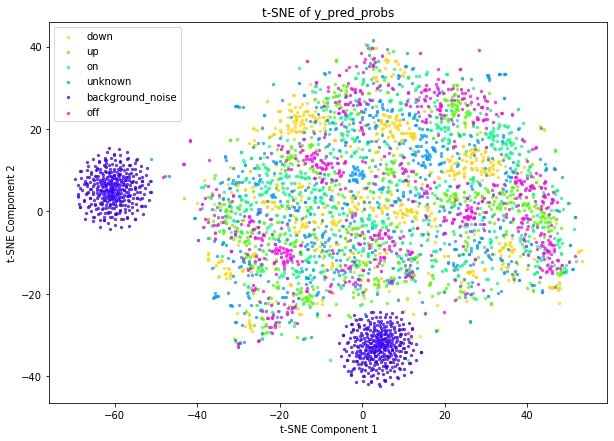

In [64]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
print(y_train.shape)
model = build_model(input_shape, learning_rate=LEARNING_RATE)


# Making predictions on the test set
y_pred_probs = model.predict(X_test)  # Assuming model output probabilities for each class


# Step 1: Standardize the data
scaler = StandardScaler()
y_pred_probs_scaled = scaler.fit_transform(y_pred_probs)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(y_pred_probs_scaled)

# Plot the data with different colors for different classes
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(Class))  # Choose a color palette

for i, label in enumerate(Class):
    idx = y_test == i
    plt.scatter(principal_components[idx, 0], principal_components[idx, 1], 
                s=5, alpha=0.7, color=palette[i], label=Class[i])

plt.title('PCA of y_pred_probs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(y_pred_probs_scaled)

# Plot the data with different colors for different classes
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(Class)) # Choose a color palette

for i, label in enumerate(Class):
    idx = y_test == i
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], s=5, alpha=0.7, color=palette[i], label=Class[i])

plt.title('t-SNE of y_pred_probs')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

# 1D-CNN

In [10]:
############################# Run one time for removing the axis #########################
# Remove the added axis
X_train = np.squeeze(X_train, axis=-1)
X_test = np.squeeze(X_test, axis=-1)
X_validation = np.squeeze(X_validation, axis=-1)

###########################################################################################

In [24]:
def build_model(input_shape, learning_rate, loss="sparse_categorical_crossentropy"):
    model = tf.keras.models.load_model('/home/soumen/Soumen/model/KWS/project_1/1D_CNN.keras')
    
    # # Get the number of layers in the pre-trained model
    num_layers = len(model.layers)
    #print(num_layers)

#    # Extract and print the weights of each layer
#     for i, layer in enumerate(model.layers):
#         if layer.trainable:
#             print(f"Layer {i}: {layer.name}")
#             weights = layer.get_weights()
            
#             #print(weights)
#             if weights:
#                 for j, w in enumerate(weights):
#                     print(f"  Weight {j}: shape={w.shape}")
                    
#             else:
#                 print("  No trainable weights")

     # Extract the input of fast layer
    input_layer_input = model.layers[-8].input
    #print(input_layer_input.shape)
    # Extract the output of the second last layer
    last_layer_output = model.layers[-4].output   #-2
    #print(last_layer_output.shape)


    # Freeze all layers except the last one
    count = 0
    for layer in model.layers[:-4]:    #-1
        layer.trainable = False
        count += 1
        #print(count)
    
    
     # Create the transfer learning model using Functional API
    model = Model(inputs=input_layer_input, outputs=last_layer_output)

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)  #, decay=0.0)

    model.compile(optimizer=optimiser, loss=loss,metrics=["accuracy"])  

    model.summary()
    
    return model


(14457, 61, 13)
(14457,)


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 61, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 57, 500)        │        33,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 26, 500)        │     1,750,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 26, 500)        │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 26, 500)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 500)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,034,000 (7.76 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,034,000 (7.76 MB)

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


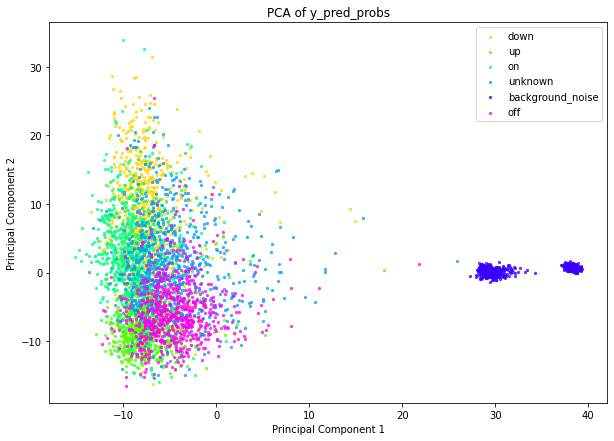

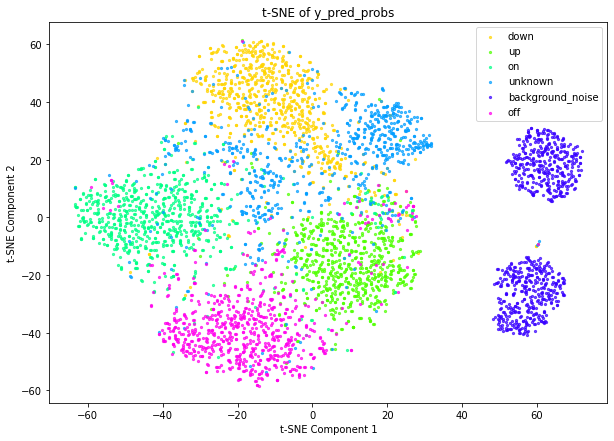

In [25]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
print(y_train.shape)
model = build_model(input_shape, learning_rate=LEARNING_RATE)


# Making predictions on the test set
y_pred_probs = model.predict(X_test)  # Assuming model output probabilities for each class

# Standardize the data
scaler = StandardScaler()
y_pred_probs_scaled = scaler.fit_transform(y_pred_probs)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(y_pred_probs_scaled)

# Plot the data with different colors for different classes
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(Class))  # Choose a color palette

for i, label in enumerate(Class):
    idx = y_test == i
    plt.scatter(principal_components[idx, 0], principal_components[idx, 1], 
                s=5, alpha=0.7, color=palette[i], label=Class[i])

plt.title('PCA of y_pred_probs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(y_pred_probs_scaled)

# Plot the data with different colors for different classes
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(Class)) # Choose a color palette

for i, label in enumerate(Class):
    idx = y_test == i
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], s=5, alpha=0.7, color=palette[i], label=Class[i])

plt.title('t-SNE of y_pred_probs')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

# TCN

In [19]:
def build_model(input_shape, learning_rate, loss="sparse_categorical_crossentropy"):
    model = tf.keras.models.load_model('/home/soumen/Soumen/model/KWS/project_1/TCN.keras')
    
    # # Get the number of layers in the pre-trained model
    num_layers = len(model.layers)
    #print(num_layers)

#    # Extract and print the weights of each layer
#     for i, layer in enumerate(model.layers):
#         if layer.trainable:
#             print(f"Layer {i}: {layer.name}")
#             weights = layer.get_weights()
            
#             #print(weights)
#             if weights:
#                 for j, w in enumerate(weights):
#                     print(f"  Weight {j}: shape={w.shape}")
                    
#             else:
#                 print("  No trainable weights")

     # Extract the input of fast layer
    input_layer_input = model.layers[-23].input
    #print(input_layer_input.shape)
    # Extract the output of the second last layer
    last_layer_output = model.layers[-5].output   #-2
    print(last_layer_output.shape)


    # Freeze all layers except the last one
    count = 0
    for layer in model.layers[:-5]:    #-1
        layer.trainable = False
        count += 1
        #print(count)
    
    
     # Create the transfer learning model using Functional API
    model = Model(inputs=input_layer_input, outputs=last_layer_output)

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)  #, decay=0.0)

    model.compile(optimizer=optimiser, loss=loss,metrics=["accuracy"])  

    model.summary()
    
    return model

(14457, 61, 13)
(14457,)
(None, 128)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 61, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 61, 32)    │      1,280 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 32)    │        128 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 61, 32)    │        448 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 61, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 32)    │        128 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 61, 32)    │          0 │ activation_5[0][… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 61, 64)    │      6,208 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 64)    │        256 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 61, 64)    │      2,112 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 61, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 64)    │        256 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 61, 64)    │          0 │ activation_6[0][… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 61, 128)   │     24,704 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 128)   │        512 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 61, 128)   │      8,320 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 61, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 128)   │        512 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 61, 128)   │          0 │ activation_7[0][

 Total params: 44,864 (175.25 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 44,864 (175.25 KB)

142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
(4518, 128)


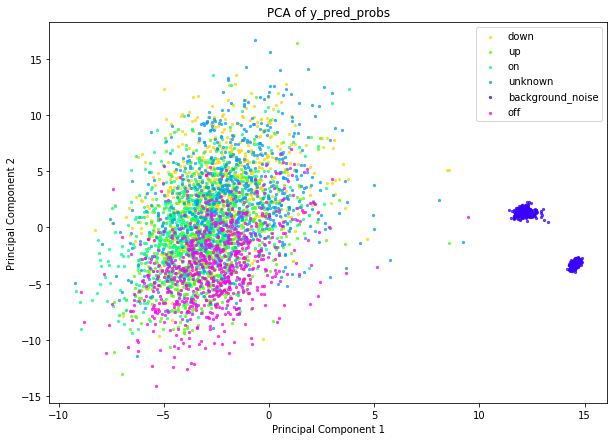

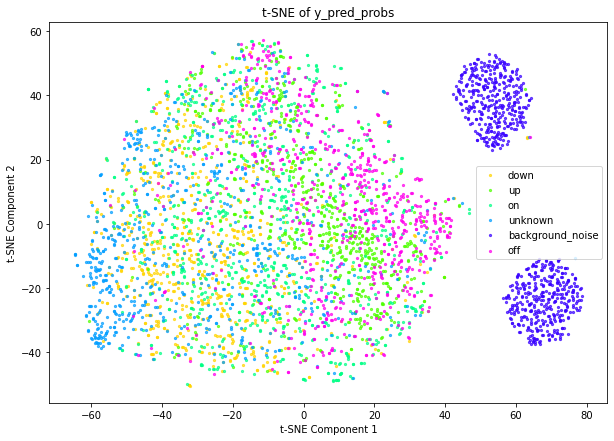

In [20]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
print(y_train.shape)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

#print(X_test.shape)
# Making predictions on the test set
y_pred_probs = model.predict(X_test)  # Assuming model output probabilities for each class
print(y_pred_probs.shape)

# Standardize the data
scaler = StandardScaler()
y_pred_probs_scaled = scaler.fit_transform(y_pred_probs)


# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(y_pred_probs_scaled)

# Plot the data with different colors for different classes
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(Class))  # Choose a color palette

for i, label in enumerate(Class):
    idx = y_test == i
    plt.scatter(principal_components[idx, 0], principal_components[idx, 1], 
                s=5, alpha=0.7, color=palette[i], label=Class[i])

plt.title('PCA of y_pred_probs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(y_pred_probs_scaled)

# Plot the data with different colors for different classes
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(Class)) # Choose a color palette

for i, label in enumerate(Class):
    idx = y_test == i
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], s=5, alpha=0.7, color=palette[i], label=Class[i])

plt.title('t-SNE of y_pred_probs')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()